In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# 读取数据

In [2]:
#封装函数

In [2]:
import copy


from itertools import groupby
from operator import itemgetter

import re
from fuzzywuzzy import fuzz


#获得最长序列用于定位
def max_length(frag):
    max_len = -1
    for i in range(len(frag)):
        if len(frag[i][0]) >= max_len:
            max_len = len(frag[i][0])
            loc = i
    return max_len, loc

#获得序列的全部定位
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

#合并间隔过小的区间
def recursive_merge(inter, window, start_index=0):
    for i in range(start_index, len(inter) - 1):
        if inter[i+1][1][0] - inter[i][1][-1] <= window:
            new_start = inter[i][1][0]
            new_end = inter[i+1][1][-1]
            inter[i][0] = str(inter[i][0])+"."*(inter[i+1][1][0]-inter[i][1][-1]-1)+str(inter[i+1][0])
            inter[i][1] = [new_start, new_end]
            del inter[i+1]
            return recursive_merge(inter, window, start_index=i)
    return inter        


def fix(middle, extend, full_revised, structure_revised):
    if (middle-extend>=0 and middle+extend<len(full_revised)):
        full_revised_fixed=full_revised
        structure_revised_fixed=structure_revised
    elif (middle-extend<0 and middle+extend>=len(full_revised)):
        full_revised_fixed="N"*abs(middle-extend)+full_revised+"N"*abs(middle+extend-len(full_revised)+1)
        structure_revised_fixed="?"*abs(middle-extend)+structure_revised+"?"*abs(middle+extend-len(structure_revised)+1)
    elif (middle-extend>=0 and middle+extend>=len(full_revised)):
        full_revised_fixed=full_revised+"N"*abs(middle+extend-len(full_revised)+1)
        structure_revised_fixed=structure_revised+"?"*abs(middle+extend-len(structure_revised)+1)   
    elif (middle-extend<0 and middle+extend<len(full_revised)):
        full_revised_fixed="N"*abs(middle-extend)+full_revised
        structure_revised_fixed="?"*abs(middle-extend)+structure_revised 
    return full_revised_fixed, structure_revised_fixed
#full_revised, structure_revised=fix(middle, extend, full_revised, structure_revised)       


#序列延伸

def read_extend(start,end,middle,extend,full_revised,structure_revised,SMILES,id, ligand, RMSD, Affinity, Weight):
    if start>=0 and end<len(full_revised): 
        print(str(id)+"\t"+str(ligand)+"\t"+str(SMILES)+"\t"+str(full_revised[start:end+1])+"\t"+str(structure_revised[start:end+1])+"\t"+str(RMSD)+"\t"+str(Affinity)+"\t"+str(Weight))
    elif start<0 and end>=len(full_revised): #两端N               
        print(str(id)+"\t"+str(ligand)+"\t"+str(SMILES)+"\t"+"N"*abs(start)+str(full_revised[0:end+1])+"N"*(end-len(full_revised)+1)+"\t"+"?"*abs(start)+str(structure_revised[0:end+1])+"?"*(end-len(structure_revised)+1)+"\t"+str(RMSD)+"\t"+str(Affinity)+"\t"+str(Weight)) 
    elif start>=0 and end>=len(full_revised): #末尾N
        print(str(id)+"\t"+str(ligand)+"\t"+str(SMILES)+"\t"+str(full_revised[start:end])+"N"*(end-len(full_revised)+1)+"\t"+str(structure_revised[start:end])+"?"*(end-len(structure_revised)+1)+"\t"+str(RMSD)+"\t"+str(Affinity)+"\t"+str(Weight))
    elif start<0 and end<len(full_revised): #起始N 
        print(str(id)+"\t"+str(ligand)+"\t"+str(SMILES)+"\t"+"N"*abs(start)+str(full_revised[0:end+1])+"\t"+"?"*abs(start)+str(structure_revised[0:end+1])+"\t"+str(RMSD)+"\t"+str(Affinity)+"\t"+str(Weight)) 


"""
#序列延伸并修正(待修改)
def read_extend(start,end,middle,extend,full_revised,structure_revised,SMILES,id):
    #根据延伸长度再次修正full_revised
    #full_revised, structure_revised=fix(middle, extend, full_revised, structure_revised)
    if(full_revised[start]!="N" and full_revised[end]!="N"):
        if start>=0 and end<len(full_revised): 
            print(str(id)+"\t"+str(SMILES)+"\t"+str(full_revised[start:end+1])+"\t"+str(structure_revised[start:end+1]))
        elif start<0 and end>=len(full_revised): #两端N               
            print(str(id)+"\t"+str(SMILES)+"\t"+"N"*abs(start)+str(full_revised[0:end+1])+"N"*(end-len(full_revised)+1)+"\t"+"?"*abs(start)+str(structure_revised[0:end+1])+"?"*(end-len(structure_revised)+1)) 
        elif start>=0 and end>=len(full_revised): #末尾N
            print(str(id)+"\t"+str(SMILES)+"\t"+str(full_revised[start:end])+"N"*(end-len(full_revised)+1)+"\t"+str(structure_revised[start:end])+"?"*(end-len(structure_revised)+1))
        elif start<0 and end<len(full_revised): #起始N 
            print(str(id)+"\t"+str(SMILES)+"\t"+"N"*abs(start)+str(full_revised[0:end+1])+"\t"+"?"*abs(start)+str(structure_revised[0:end+1])) 
    elif(full_revised[start]=="N" and full_revised[end]=="N"):
        print("N--N")
    elif(full_revised[start]=="N" and full_revised[end]!="N"):
        print("N--")
    elif(full_revised[start]!="N" and full_revised[end]=="N"):
        print("--N")       
"""

def ext(element,extend):
    id=element[0]
    ligand=element[1]
    SMILES=element[2]
    full=element[3]
    structure=element[4]
    Position=element[5]
    Fragment=element[6]
    RMSD=element[7]
    Affinity=element[8]   
    Weight=element[9]      
    

    
    extend=15
    length=extend*2+1  
    print(str(id)+"\t"+str(ligand)+"\t"+str(SMILES)+"\t"+ str(full)+"N"*abs(length-len(full))+"\t"+str(structure)+"?"*abs(length-len(full))+"\t"+str(RMSD)+"\t"+str(Affinity)+"\t"+str(Weight)) 




def cal(element,extend,win):
    
    id=element[0]
    ligand=element[1]
    SMILES=element[2]
    full=element[3]
    structure=element[4]
    pos=element[5]
    part=element[6]
    RMSD=element[7]
    Affinity=element[8]   
    Weight=element[9]       
    
    
    frag=[]
    data=list(pos.split(","))
    data = list(map(int, data))
    for k, g in groupby(enumerate(data), lambda ix : ix[0] - ix[1]):
        sequence=[]
        a=list(map(itemgetter(1), g))
        for i in range(len(a)):
            sequence.append(part[data.index(a[i])])
        frag.append([''.join(sequence)]+[a])
  
    
    max_len,loc = max_length(frag)
    
    #print(frag)
    
    if(max_len>=5):
        read=frag[loc][0]
        pdb_start=frag[loc][1][0]
        pos_list=list(find_all(full.upper(),read.upper()))
        if len(pos_list)==0:
            real_start="NULL"
        elif len(pos_list)==1: #如果只匹配到一个位置，则选取该位置
            real_start=pos_list[0]+1
            #print(pos)
        else: #如果匹配到多个位置，则选取最近的
            real_start=min(pos_list, key=lambda x:abs(x-pdb_start))+1
        frag_old = copy.deepcopy(frag)
        frag_merge=recursive_merge(frag, window=win) #判断片段之间间隔是否小于5bp并合并
        
        
        
    ###################################最长的片段位置与注释位置一致################################################################ 
        if (real_start=="NULL"):
            print("wrong")  
        elif(real_start==pdb_start):
            #print(full)
            #print(frag_merge)
            for i in range(len(frag_merge)):
                middle=int((frag_merge[i][1][0]+frag_merge[i][1][-1])/2+0.5)
                #print(middle)
                read_extend(middle-extend-1,middle+extend-1,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight)
                
    ##################################最长的片段位置与注释位置不一致###############################################################
        elif(real_start!=pdb_start):
            #print(real_start,pdb_start,read)
            if (real_start<pdb_start): #最长的片段位置小于注释位置,在起始位置补N
                real_last=frag_merge[-1][1][-1]
                full_revised=''.join(["N"*int(pdb_start-real_start),full]) 
                structure_revised=''.join(["?"*int(pdb_start-real_start),structure]) 

                if(real_last>len(full_revised)): #修正全长序列尾部
                    full_revised=str(full_revised)+"N"*int(real_last-len(full_revised))+str(frag_merge[-1][0])
                    structure_revised=str(structure_revised)+"?"*int(real_last-len(structure_revised))+str(frag_merge[-1][0])
            elif (real_start>pdb_start):
                real_last=frag_merge[-1][1][-1] #最长的片段位置大于注释位置,从前端删除碱基
                full_revised=full[int(real_start-pdb_start):]
                structure_revised=structure[int(real_start-pdb_start):]

                if(real_last>len(full_revised)): #修正全长序列尾部
                    full_revised=str(full_revised)+"N"*int(real_last-len(full_revised))+str(frag_merge[-1][0])
                    structure_revised=str(structure_revised)+"?"*int(real_last-len(structure_revised))+str(frag_merge[-1][0])
                
            #print(full_revised)
            #print(structure_revised)
            #print(frag_merge)

            for i in range(len(frag_merge)):  #合并后的片段获得中间位置并延伸
                #if frag_merge[i][1][0]==frag_merge[i][1][-1]:
                #    sequence=full_revised[frag_merge[i][1][0]]
                #else:
                #print(i)
                if(len(frag_merge[i][0])>=6): #如果merge后序列长度大于6
                    if re.search(frag_merge[i][0], full_revised):
                        real_start=re.search(frag_merge[i][0], full_revised).start()+1
                        if(real_start==frag_merge[i][1][0]):
                            start=frag_merge[i][1][0]
                            end=frag_merge[i][1][-1]
                            middle=int((start+end)/2+0.5)
                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                        elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                            start=frag_merge[i][1][0]
                            end=frag_merge[i][1][-1]
                            middle=int((start+end)/2+0.5)
                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight) 
                        else: #尝试不改变原序列是否可以匹配上
                            if re.search(frag_merge[i][0], full):
                                real_start=re.search(frag_merge[i][0], full).start()+1
                                if(real_start==frag_merge[i][1][0]):
                                    start=frag_merge[i][1][0]
                                    end=frag_merge[i][1][-1]
                                    middle=int((start+end)/2+0.5)
                                    read_extend(middle-extend-1,middle+extend-1,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight)
                                elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                                    start=frag_merge[i][1][0]
                                    end=frag_merge[i][1][-1]
                                    middle=int((start+end)/2+0.5)
                                    read_extend(middle-extend-1,middle+extend-1,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight) 
                                else:#存在多重匹配的情况，将前者mask,取后者
                                    full_revised_tmp=full_revised[re.search(frag_merge[i][0], full_revised).start()+len(frag_merge[i][0]):] 
                                    full_revised_mask="N"*int(re.search(frag_merge[i][0], full_revised).start()+len(frag_merge[i][0]))+str(full_revised_tmp)
                                    #print(full_tmp)
                                    #print(full_revised_mask)
                                    if re.search(frag_merge[i][0], full_revised_mask):
                                        real_start=re.search(frag_merge[i][0], full_revised_mask).start()+1
                                        if(real_start==frag_merge[i][1][0]):
                                            start=frag_merge[i][1][0]
                                            end=frag_merge[i][1][-1]
                                            middle=int((start+end)/2+0.5)
                                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                        elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                                            start=frag_merge[i][1][0]
                                            end=frag_merge[i][1][-1]
                                            middle=int((start+end)/2+0.5)
                                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight) 
                                    else:
                                        print("long_1_error"+'\t'+str(id)+"\t"+str(ligand))

                    else:
                        #print("unmatched_error")
                        sequence=full_revised[frag_merge[i][1][0]:frag_merge[i][1][-1]+1]
                        fragment=str(frag_merge[i][0]).replace(".","")
                        cmp=fuzz.ratio(sequence, fragment)
                        #print(sequence,fragment,cmp_global,frag_merge[i][1][0],frag_merge[i][1][-1]+1)
                        if(cmp>=80):
                            start=frag_merge[i][1][0]
                            end=frag_merge[i][1][-1]
                            middle=int((start+end)/2+0.5)
                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                        else:
                            print("long_unmatched_error")
                else:#如果merge后序列长度小于6
                    if(len(frag_merge)>=2):
                        if i==0: #向后拼接
                            frag_merge_concat = str(frag_merge[i][0])+"."*int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)+str(frag_merge[i+1][0])
                            #print(frag_merge_concat)
                            if(re.search(frag_merge_concat,full_revised)):
                                start=re.search(frag_merge_concat,full_revised).start()+1
                                end=start+len(frag_merge[i][0])-1
                                middle=int((start+end)/2+0.5)
                                read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                            else:
                                if i!=0:#如果不是第一个
                                    frag_merge_concat = str(frag_merge[i-1][0])+"."*int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+str(frag_merge[i][0]) #无法匹配后，尝试向前拼接
                                    #print(frag_merge_concat)
                                    if(re.search(frag_merge_concat,full_revised)):
                                        start=re.search(frag_merge_concat,full_revised).start()+len(frag_merge[i-1][0])+int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+1
                                        end=start+len(frag_merge[i][0])-1
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)   
                                    else:
                                        print("long_2_error")
                                        
                                else:
                                    #尝试允许偏移
                                    #print(frag_merge_concat)
                                    dot=int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)
                                    for j in range(dot):
                                        frag_merge_concat=str(frag_merge[i][0])+"."*int(dot-j)+str(frag_merge[i+1][0])
                                        if(re.search(frag_merge_concat, full_revised)):
                                            delete=j
                                            #print(delete)
                                            break
                                        else:
                                            continue
                                    if(re.search(frag_merge_concat, full_revised)):
                                        start=re.search(frag_merge_concat, full_revised).start()+1
                                        end=start+len(frag_merge[i][0])
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                    else:
                                        frag_merge_concat = str(frag_merge[i][0])+"."*int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)+str(frag_merge[i+1][0]) #无法匹配后，尝试向前拼接
                                        dot=int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)
                                        for j in range(dot*2):
                                            frag_merge_concat=str(frag_merge[i][0])+"."*int(dot+j)+str(frag_merge[i+1][0])
                                            if(re.search(frag_merge_concat, full_revised)):
                                                delete=j
                                                #print(delete)
                                                break
                                            else:
                                                continue
                                        if(real_start<pdb_start):#从尾部删除碱基
                                            if(re.search(frag_merge_concat, full_revised)):
                                                #print(frag_merge_concat)
                                                #print(full_revised)
                                                start=re.search(frag_merge_concat, full_revised).start()+1
                                                end=start+len(frag_merge[i][0])
                                                middle=int((start+end)/2+0.5)

                                                read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                            else:
                                                print("long_unconcat1.1_error")
                                        elif(real_start>pdb_start): #从头部删除碱基 #3P49
                                            if(re.search(frag_merge_concat, full)):
                                                #print(frag_merge_concat)
                                                #print(full_revised)
                                                start=re.search(frag_merge_concat, full).start()+1
                                                end=start+len(frag_merge[i][0])
                                                middle=int((start+end)/2+0.5)
                                                read_extend(middle-extend-1,middle+extend-1,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight)
                                            else:
                                                print(frag_merge_concat)
                                                print("long_unconcat1.2_error")
          
                        else: #向前拼接
                            frag_merge_concat = str(frag_merge[i-1][0])+"."*int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+str(frag_merge[i][0])
                            #print(frag_merge_concat)
                            if(re.search(frag_merge_concat,full_revised)):
                                start=re.search(frag_merge_concat,full_revised).start()+len(frag_merge[i-1][0])+int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+1
                                end=start+len(frag_merge[i][0])-1
                                middle=int((start+end)/2+0.5)
                                read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                            else:
                                if i!=len(frag_merge)-1:#如果不是最后一个
                                    frag_merge_concat = str(frag_merge[i][0])+"."*int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)+str(frag_merge[i+1][0]) #无法匹配后，尝试向后拼接
                                    if(re.search(frag_merge_concat,full_revised)):
                                        start=re.search(frag_merge_concat,full_revised).start()+1
                                        end=start+len(frag_merge[i][0])-1
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                    else:
                                        print("long_3_error")
                                else:
                                    #print("long_unconcat2")
                                    #尝试允许偏移
                                    #print(frag_merge_concat)
                                    dot=int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)
                                    for j in range(dot):
                                        frag_merge_concat=str(frag_merge[i-1][0])+"."*int(dot-j)+str(frag_merge[i][0])
                                        if(re.search(frag_merge_concat, full_revised)):
                                            delete=j
                                            #print(delete)
                                            break
                                        else:
                                            continue
                                    if(re.search(frag_merge_concat, full_revised)):
                                        start=re.search(frag_merge_concat, full_revised).start()+len(frag_merge[i-1][0])+int(dot-delete)+1
                                        end=start+len(frag_merge[i][0])
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                    else:
                                        print("long_unconcat2_error")
                    else:
                        print("long0_error")
                        
                            
    elif (max_len<5) and (len(frag)>=2): #如果定位序列小于5bp,并且片段个数足够用于拼接定位
        #print(frag)
        #print(full)
        read=frag[loc]
        pdb_start=read[1][0]
        if(loc==0):#向后拼接
            read_after=frag[loc+1]
            read_concat=read[0]+"."*(read_after[1][0]-read[1][-1]-1)+str(read_after[0]) 
        elif(loc>=1):#向前拼接
            read_before=frag[loc-1]
            read_concat=str(read_before[0])+"."*(read[1][0]-read_before[1][-1]-1)+str(read[0])
        #print(read_concat)
        
        
        if (re.search(read_concat, full) and loc==0):#向后拼接并定位
            real_start=re.search(read_concat, full).start()+1
        elif (re.search(read_concat, full) and loc>=1):#向前拼接并定位
            real_start=re.search(read_concat, full).start()+len(read_before)+(read[1][0]-read_before[1][-1]-1)          
        else:
            real_start="NULL"
        #print(real_start)
        frag_old = copy.deepcopy(frag)
        frag_merge=recursive_merge(frag, window=win) #判断片段之间间隔是否小于5bp并合并
    ###################################最长的片段位置与注释位置一致################################################################ 
        if (real_start=="NULL"):
            print("error")  
        elif(real_start==pdb_start):
            for i in range(len(frag_merge)):
                middle=int((frag_merge[i][1][0]+frag_merge[i][1][-1])/2+0.5)
                read_extend(middle-extend,middle+extend,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight)
    ##################################最长的片段位置与注释位置不一致###############################################################            
        elif(real_start!=pdb_start):
            #print(real_start,pdb_start,read)
            if (real_start<pdb_start): #最长的片段位置小于注释位置,在起始位置补N
                real_last=frag_merge[-1][1][-1]
                full_revised=''.join(["N"*int(pdb_start-real_start),full]) 
                structure_revised=''.join(["?"*int(pdb_start-real_start),structure]) 

                if(real_last>len(full_revised)): #修正全长序列尾部
                    full_revised=str(full_revised)+"N"*int(real_last-len(full_revised))+str(frag_merge[-1][0])
                    structure_revised=str(structure_revised)+"?"*int(real_last-len(structure_revised))+str(frag_merge[-1][0])
            elif (real_start>pdb_start):
                real_last=frag_merge[-1][1][-1] #最长的片段位置大于注释位置,从前端删除碱基
                full_revised=full[int(real_start-pdb_start):]
                structure_revised=structure[int(real_start-pdb_start):]

                if(real_last>len(full_revised)): #修正全长序列尾部
                    full_revised=str(full_revised)+"N"*int(real_last-len(full_revised))+str(frag_merge[-1][0])
                    structure_revised=str(structure_revised)+"?"*int(real_last-len(structure_revised))+str(frag_merge[-1][0])
                
            #print(full_revised)
            #print(structure_revised)
            #print(frag_merge)

            for i in range(len(frag_merge)):  #合并后的片段获得中间位置并延伸
                #if frag_merge[i][1][0]==frag_merge[i][1][-1]:
                #    sequence=full_revised[frag_merge[i][1][0]]
                #else:
                #print(i)
                if(len(frag_merge[i][0])>=6): #如果merge后序列长度大于6
                    if re.search(frag_merge[i][0], full_revised):
                        real_start=re.search(frag_merge[i][0], full_revised).start()+1
                        if(real_start==frag_merge[i][1][0]):
                            start=frag_merge[i][1][0]
                            end=frag_merge[i][1][-1]
                            middle=int((start+end)/2+0.5)
                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                        elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                            start=frag_merge[i][1][0]
                            end=frag_merge[i][1][-1]
                            middle=int((start+end)/2+0.5)
                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight) 
                        else: #尝试不改变原序列是否可以匹配上
                            if re.search(frag_merge[i][0], full):
                                real_start=re.search(frag_merge[i][0], full).start()+1
                                if(real_start==frag_merge[i][1][0]):
                                    start=frag_merge[i][1][0]
                                    end=frag_merge[i][1][-1]
                                    middle=int((start+end)/2+0.5)
                                    read_extend(middle-extend-1,middle+extend-1,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight)
                                elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                                    start=frag_merge[i][1][0]
                                    end=frag_merge[i][1][-1]
                                    middle=int((start+end)/2+0.5)
                                    read_extend(middle-extend-1,middle+extend-1,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight) 
                                else:#存在多重匹配的情况，将前者mask,取后者
                                    full_revised_tmp=full_revised[re.search(frag_merge[i][0], full_revised).start()+len(frag_merge[i][0]):] 
                                    full_revised_mask="N"*int(re.search(frag_merge[i][0], full_revised).start()+len(frag_merge[i][0]))+str(full_revised_tmp)
                                    #print(full_tmp)
                                    #print(full_revised_mask)
                                    if re.search(frag_merge[i][0], full_revised_mask):
                                        real_start=re.search(frag_merge[i][0], full_revised_mask).start()+1
                                        if(real_start==frag_merge[i][1][0]):
                                            start=frag_merge[i][1][0]
                                            end=frag_merge[i][1][-1]
                                            middle=int((start+end)/2+0.5)
                                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                        elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                                            start=frag_merge[i][1][0]
                                            end=frag_merge[i][1][-1]
                                            middle=int((start+end)/2+0.5)
                                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight) 
                                    else:
                                        print("short_1_error"+'\t'+str(id)+"\t"+str(ligand))

                    else:
                        sequence=full_revised[frag_merge[i][1][0]:frag_merge[i][1][-1]+1]
                        fragment=str(frag_merge[i][0]).replace(".","")
                        cmp=fuzz.ratio(sequence, fragment)
                        #print(sequence,fragment,cmp_global,frag_merge[i][1][0],frag_merge[i][1][-1]+1)
                        if(cmp>=80):
                            start=frag_merge[i][1][0]
                            end=frag_merge[i][1][-1]
                            middle=int((start+end)/2+0.5)
                            read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                        else:
                            print("short_unmatched_error")
                else:#如果merge后序列长度小于6
                    if(len(frag_merge)>=2):
                        if i==0: #向后拼接
                            frag_merge_concat = str(frag_merge[i][0])+"."*int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)+str(frag_merge[i+1][0])
                            #print(frag_merge_concat)
                            if(re.search(frag_merge_concat,full_revised)):
                                start=re.search(frag_merge_concat,full_revised).start()+1
                                end=start+len(frag_merge[i][0])-1
                                middle=int((start+end)/2+0.5)
                                read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                            else:
                                if i!=0:#如果不是第一个
                                    frag_merge_concat = str(frag_merge[i-1][0])+"."*int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+str(frag_merge[i][0]) #无法匹配后，尝试向前拼接
                                    #print(frag_merge_concat)
                                    if(re.search(frag_merge_concat,full_revised)):
                                        start=re.search(frag_merge_concat,full_revised).start()+len(frag_merge[i-1][0])+int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+1
                                        end=start+len(frag_merge[i][0])-1
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)   
                                    else:
                                        print("short_2_error")
                                        
                                else:
                                    #尝试允许偏移
                                    #print(frag_merge_concat)
                                    dot=int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)
                                    for j in range(dot):
                                        frag_merge_concat=str(frag_merge[i][0])+"."*int(dot-j)+str(frag_merge[i+1][0])
                                        if(re.search(frag_merge_concat, full_revised)):
                                            delete=j
                                            #print(delete)
                                            break
                                        else:
                                            continue
                                    if(re.search(frag_merge_concat, full_revised)):
                                        start=re.search(frag_merge_concat, full_revised).start()+1
                                        end=start+len(frag_merge[i][0])
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                    else:
                                        print("short_unconcat1_error")
          
                        else: #向前拼接
                            frag_merge_concat = str(frag_merge[i-1][0])+"."*int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+str(frag_merge[i][0])
                            #print(frag_merge_concat)
                            if(re.search(frag_merge_concat,full_revised)):
                                start=re.search(frag_merge_concat,full_revised).start()+len(frag_merge[i-1][0])+int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)+1
                                end=start+len(frag_merge[i][0])-1
                                middle=int((start+end)/2+0.5)
                                read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                            else:
                                if i!=len(frag_merge)-1:#如果不是最后一个
                                    frag_merge_concat = str(frag_merge[i][0])+"."*int(frag_merge[i+1][1][0]-frag_merge[i][1][-1]-1)+str(frag_merge[i+1][0]) #无法匹配后，尝试向后拼接
                                    if(re.search(frag_merge_concat,full_revised)):
                                        start=re.search(frag_merge_concat,full_revised).start()+1
                                        end=start+len(frag_merge[i][0])-1
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                    else:
                                        print("short_3_error"+'\t'+str(id)+"\t"+str(ligand))
                                else:
                                    #print("long_unconcat2")
                                    #尝试允许偏移
                                    #print(frag_merge_concat)
                                    dot=int(frag_merge[i][1][0]-frag_merge[i-1][1][-1]-1)
                                    for j in range(dot):
                                        frag_merge_concat=str(frag_merge[i-1][0])+"."*int(dot-j)+str(frag_merge[i][0])
                                        if(re.search(frag_merge_concat, full_revised)):
                                            delete=j
                                            #print(delete)
                                            break
                                        else:
                                            continue
                                    if(re.search(frag_merge_concat, full_revised)):
                                        start=re.search(frag_merge_concat, full_revised).start()+len(frag_merge[i-1][0])+int(dot-delete)+1
                                        end=start+len(frag_merge[i][0])
                                        middle=int((start+end)/2+0.5)
                                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                                    else:
                                        print("short_unconcat2_error")
                    else:
                        print("short0_error")
                        

 
        
    elif (max_len<5) and (len(frag)==1):
        read=frag[loc][0]
        pdb_start=frag[loc][1][0]
        pos_list=list(find_all(full.upper(),read.upper()))
        if len(pos_list)==0:
            real_start="NULL"
        elif len(pos_list)==1: #如果只匹配到一个位置，则选取该位置
            real_start=pos_list[0]+1
            #print(pos)
        else: #如果匹配到多个位置，则选取最近的
            real_start=min(pos_list, key=lambda x:abs(x-pdb_start))+1
        frag_old = copy.deepcopy(frag)
        frag_merge=recursive_merge(frag, window=win) #判断片段之间间隔是否小于5bp并合并
    ###################################最长的片段位置与注释位置一致################################################################ 
        if (real_start=="NULL"):
            print("error")  
        elif(real_start==pdb_start):
            for i in range(len(frag_merge)):
                middle=int((frag_merge[i][1][0]+frag_merge[i][1][-1])/2+0.5)
                read_extend(middle-extend,middle+extend,middle,extend,full,structure,SMILES,id,ligand,RMSD,Affinity,Weight)
    ##################################最长的片段位置与注释位置不一致###############################################################              
        elif(real_start!=pdb_start):
            #print(real_start,pdb_start,read)
            if (real_start<pdb_start): #最长的片段位置小于注释位置,在起始位置补N
                real_last=frag_merge[-1][1][-1]
                full_revised=''.join(["N"*int(pdb_start-real_start),full]) 
                structure_revised=''.join(["?"*int(pdb_start-real_start),structure]) 

                if(real_last>len(full_revised)): #修正全长序列尾部
                    full_revised=str(full_revised)+"N"*int(real_last-len(full_revised))+str(frag_merge[-1][0])
                    structure_revised=str(structure_revised)+"?"*int(real_last-len(structure_revised))+str(frag_merge[-1][0])
            elif (real_start>pdb_start):
                real_last=frag_merge[-1][1][-1] #最长的片段位置大于注释位置,从前端删除碱基
                full_revised=full[int(real_start-pdb_start):]
                structure_revised=structure[int(real_start-pdb_start):]

                if(real_last>len(full_revised)): #修正全长序列尾部
                    full_revised=str(full_revised)+"N"*int(real_last-len(full_revised))+str(frag_merge[-1][0])
                    structure_revised=str(structure_revised)+"?"*int(real_last-len(structure_revised))+str(frag_merge[-1][0])
                
            #print(full_revised)
            #print(structure_revised)
            #print(frag_merge)

            for i in range(len(frag_merge)):  #合并后的片段获得中间位置并延伸
                if re.search(frag_merge[i][0], full_revised):
                    real_start=re.search(frag_merge[i][0], full_revised).start()+1
                    if(real_start==frag_merge[i][1][0]):
                        start=frag_merge[i][1][0]
                        end=frag_merge[i][1][-1]
                        middle=int((start+end)/2+0.5)
                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight)
                    elif(frag_merge[i][1][0]>=real_start-6 and frag_merge[i][1][0]<=real_start+6):#(允许+5bp偏移)
                        start=frag_merge[i][1][0]
                        end=frag_merge[i][1][-1]
                        middle=int((start+end)/2+0.5)
                        read_extend(middle-extend-1,middle+extend-1,middle,extend,full_revised,structure_revised,SMILES,id,ligand,RMSD,Affinity,Weight) 
                    else:
                        print("too_short_error"+'\t'+str(id)+"\t"+str(ligand))

                else:
                    print("unfound_error")
        
        
        
    else:
        print("unknwon_error")

In [4]:
file = open("extension_autodock_ss.txt")

extend=15
win=5
cutoff=20
remove=10
"""
extend=7
win=3
cutoff=9
remove=5
"""
next(file)
print("PDB_ID"+"\t"+"Ligand_name"+"\t"+"SMILES"+"\t"+"Sequence"+"\t"+"Structure"+"\t"+"RMSD"+"\t"+"Affinity"+"\t"+"Weight")
for line in file:
    line_re=line.strip("\n")
    element=line_re.split("\t")
    #print(element[0]+"\t"+element[1]+"\t"+element[2]+"\t"+element[3]+"\t"+element[4]+"\t"+element[5]+"\t"+element[6])
    
    if (len(element[3]))>cutoff:
        cal(element,extend,win)
    elif (len(element[3]))<=cutoff and (len(element[3]))>=remove:
        ext(element,extend)
    elif (len(element[3]))<remove:
        pass


PDB_ID	Ligand_name	SMILES	Sequence	Structure	RMSD	Affinity	Weight
1AJU	ARG	NC(=[NH2+])NCCCC(N)C(=O)O	GCCAGAUUGAGCCUGGGAGCUCUCUGGCCNN	((((((..((((......)))))))))))??	3.06	-4	144.0904
1AKX	ARG	NC(=[NH2+])NCCCC(N)C(=O)O	NNNNNNNNNGGCCAGAUUGAGCCUGGGAGCU	?????????(((((((..((((......)))	12.837	-5.2	144.0904
long_unconcat2_error
1AM0	AMP	Nc1ncnc2c1ncn2C1OC(COP(=O)(O)O)C(O)C1O	GGGAAGAAACUGUAGCNNNNNNNNNNNNNNN	(...........().)???????????????	2.452	-5.9	333.1101
1ARJ	ARG	NC(=[NH2+])NCCCC(N)C(=O)O	GGCAGAUCUGAGCCUGGGAGCUCUCUGCCNN	.(((((...((((......))))))))).??	2.777	-4.9	160.0898
1BYJ	GE1	NCC1CCC(N)C(O)O1	NNNNNNNNNGGCGUCACACCUUCGGGUGAAG	?????????((((.(.((((....))))..)	0.833	-5	132.0764
1BYJ	GE1	NCC1CCC(N)C(O)O1	UCACACCUUCGGGUGAAGUCGCCNNNNNNNN	.(.((((....))))..).))))????????	0.833	-5	132.0764
1BYJ	GE2	NC1CC(N)CC(O)C1	NNNGGCGUCACACCUUCGGGUGAAGUCGCCN	???((((.(.((((....))))..).))))?	6.064	-3.9	116.077
1BYJ	GE3	CNC1C(O)C(O)OCC1(C)O	NNGGCGUCACACCUUCGGGUGAAGUCGCCNN	??((((.(.((((....))))..).))))??	8.305	-4

4P95	MES	O=S(=O)([O-])CC[NH+]1CCOCC1	NNNNNNNNNCAUCCGGUAUCCCAAGACAAUC	?????????..{((((...(((((..(((((	15.049	-4.9	182.1335
4P95	MES	O=S(=O)([O-])CC[NH+]1CCOCC1	GGUUGGGUUGGGAAGUAUCAUGGCUAAUCAC	)))))..)))))..(((((((((...[[[.)	15.049	-4.9	182.1335
4P95	MES	O=S(=O)([O-])CC[NH+]1CCOCC1	CACCAUGAUGCAAUCGGGUUGAACACUUAAU	[.)))))))))..)))).(((.((((.....	15.049	-4.9	182.1335
4Q9Q	2ZZ	CC1=NC(=Cc2cccc(Br)c2)C(=O)N1C	GACCGAAAUGGUGAAGGACGGGUCCAGUGCG	(((((..((((.(.....(...(((((((((	16.338	-6.7	268.0452
4Q9Q	2ZZ	CC1=NC(=Cc2cccc(Br)c2)C(=O)N1C	ACUGUUGAGUAGAGUGUGAGCUCCGUAACUG	))))..)).........)..).))))..).)	16.338	-6.7	268.0452
4RUM	GOL	OCC(O)CO	NNNNGGAACUGAGCAGGCAAUGACCAGAGCG	????((((((((..(.(((.((((((.....	22.074	-3.7	84.0303
4RUM	GOL	OCC(O)CO	CAGAGCGGUCAUGCAGCCGGGCUGCGAAAGC	((.....))))))...)))..(((((....)	22.074	-3.7	84.0303
4RUM	GOL	OCC(O)CO	ACGCACAUCUGUGGGACAGUUCCCACNNNNN	......)))))))..).)))))))).?????	22.074	-3.7	84.0303
4RZD	PRF	NCc1c[nH]c2nc(N)[nH]c(=O)c12	NNNNNAGCAACUUAGGAUUUUAGGCUCCCCG	?????[[[

In [62]:
from rdkit import Chem

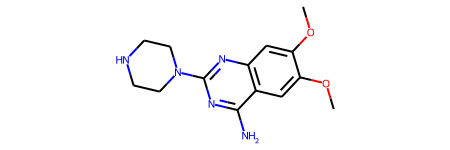

In [63]:
Chem.MolFromSmiles('COc1cc2c(cc1OC)nc(nc2N)N3CCNCC3')

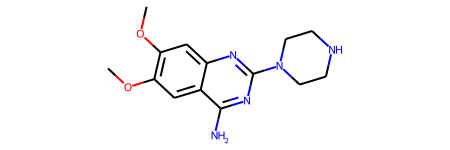

In [64]:
Chem.MolFromSmiles('COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCNCC3)N)OC')

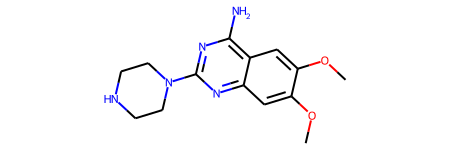

In [65]:
Chem.MolFromSmiles('COc1cc2nc(N3CCNCC3)nc(N)c2cc1OC')